# Importing All Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import LSTM, GRU
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization,LSTM,Bidirectional,MaxPooling2D,GlobalMaxPooling2D,TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix

# Importing the Data

In [2]:
data = pd.read_csv("EEG_data.csv", sep=',')

In [3]:
data.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
dtypes: float64(15)
memory usage: 1.5 MB


In [4]:
#Structure data in pandas dataframe with 64 bits floats
df = pd.DataFrame(data, dtype='f8') 

#Assign column labels
df.columns = [
    'Subject', 
    'Video',   
    'Attention', 
    'Meditation', 
    'Raw',
    'Delta', 
    'Theta', 
    'Alpha1', 
    'Alpha2', 
    'Beta1', 
    'Beta2', 
    'Gamma1', 
    'Gamma2', 
    'exp', 
    'obs'
]

#Check for missing values in df
msg_missing = 'Missing values in dataset'
assert(all(df.isnull() == False)), msg_missing

#Assign student number as major index
major = df['Subject'].values 

#Assign video number as minor index
minor = df['Video'].values

#Create MultiIndex from students and videos
df.index = pd.MultiIndex.from_arrays([major, minor])

#Name major and minor index
df.index.levels[0].set_names = 'Subject'
df.index.levels[1].set_names = 'Video'

#Remove data not part of the analysis
del df['Subject']
del df['Video']
del df['exp']
del df['Meditation']
# del df['Raw']

#Visual check of data
df[:10]

Attention    Raw      Delta     Theta    Alpha1   Alpha2    Beta1  \
0.0 0.0       56.0  278.0   302000.0   90600.0   33700.0  24000.0  27900.0   
    0.0       40.0  -50.0    73800.0   28100.0    1440.0   2240.0   2750.0   
    0.0       47.0  101.0   758000.0  384000.0  202000.0  62100.0  36300.0   
    0.0       47.0   -5.0  2010000.0  129000.0   61200.0  17100.0  11500.0   
    0.0       44.0   -8.0  1010000.0  354000.0   37100.0  88900.0  45300.0   
    0.0       44.0   73.0  1790000.0  177000.0   59400.0  26200.0  15100.0   
    0.0       43.0  130.0   635000.0  122000.0   90100.0  65100.0  36200.0   
    0.0       40.0   -2.0   161000.0   12100.0    1960.0    809.0   1280.0   
    0.0       43.0   17.0   493000.0  121000.0   63700.0  68200.0  10800.0   
    0.0       47.0  -59.0    82000.0  116000.0   47300.0  26200.0  41600.0   

            Beta2   Gamma1   Gamma2  obs  
0.0 0.0   45100.0  33200.0   8290.0  0.0  
    0.0    3690.0   5290.0   2740.0  0.0  
    0.0  131000.0  57200.0  25400.0  0.0  
    0.0   62500.0  50000.0  33900.0  0.0  
    0.0   99600.0  44800.0  29700.0  0.0  
    0.0   33700.0  33800.0  31800.0  0.0  
    0.0   53000.0  62900.0  59300.0  0.0  
    0.0    3190.0   3270.0   2520.0  0.0  
    0.0   88400.0  73800.0  22700.0  0.0  
    0.0   28900.0  32600.0  41800.0  0.0

# Correlation of the variable 

<AxesSubplot:>

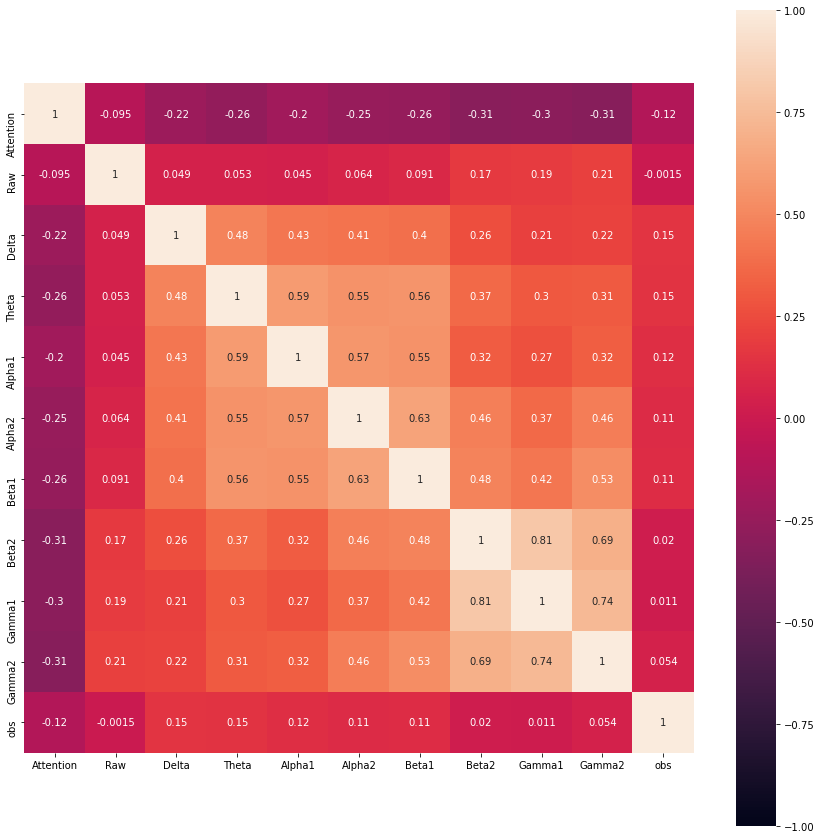

In [5]:
import seaborn as sns
plt.figure(figsize = (15, 15))
correlation = df.corr()
sns.heatmap(correlation, vmin = -1.0, square = True, annot = True)

In [6]:
df['obs'].unique()

array([0., 1.])

In [7]:
df['obs'].value_counts()

1.0    6567
0.0    6244
Name: obs, dtype: int64

In [8]:
X = np.array(df.drop(['obs'],axis = 1))
y = np.array(df['obs'])

In [9]:
X.min(), X.max()

(-2050.0, 3960000.0)

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
X = StandardScaler().fit_transform(X)

In [12]:
X.min(), X.max()

(-3.534777060086391, 37.0671107126503)

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((X,y))

In [14]:
dataset_size = X.shape[0]
dataset_size

12811

In [15]:
train_size = int(0.70 * dataset_size)
train_size

8967

In [16]:
X_train = dataset.take(train_size)
X_test = dataset.skip(train_size)

In [17]:
X_train = X_train.shuffle(len(X_train))

In [18]:
# Making batches of 32 
X_train = X_train.batch(32)
X_train

<BatchDataset shapes: ((None, 10), (None,)), types: (tf.float64, tf.float64)>

In [19]:
# model building
import tensorflow as tf
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Lambda, Dot, Concatenate,Dropout, Activation

from tensorflow.keras import backend as K

tf.keras.backend.clear_session()

In [20]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

# implementation of Attention Layer

# attention weights are softmax of (v*(w*s<t-1> + u*h))
# s<t-1> is hidden state at <t-1> of decoder and h is hidden state outputs of the encoder

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [21]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [35]:
inputs = tf.keras.Input(shape=(10, 1))#lstm takes 3d input of the shape [batch_size, timesteps, feature]
#time steps is the number of the input feature and the features is the number corresponding output value we want to predict
Dense1 = Dense(64, activation = 'relu')(inputs)
Dense2 = Dense(128, activation = 'relu')(Dense1)
lstm_1=  LSTM(256, return_sequences = True)(Dense2)
drop = Dropout(0.2)(lstm_1)
lstm_3=  LSTM(256, return_sequences = True)(drop)
drop2 = Dropout(0.2)(lstm_3)
att_ = Attention(256)(drop2)
Dense_1 = Dense(128, activation = 'relu')(att_)
outputs = Dense(1, activation='sigmoid')(Dense_1)

model = tf.keras.Model(inputs, outputs)

In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
dense_4 (Dense)              (None, 10, 64)            128       
_________________________________________________________________
dense_5 (Dense)              (None, 10, 128)           8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 256)           394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 256)           525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 256)           0   

In [37]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [38]:
bs = 32
epochs = 100

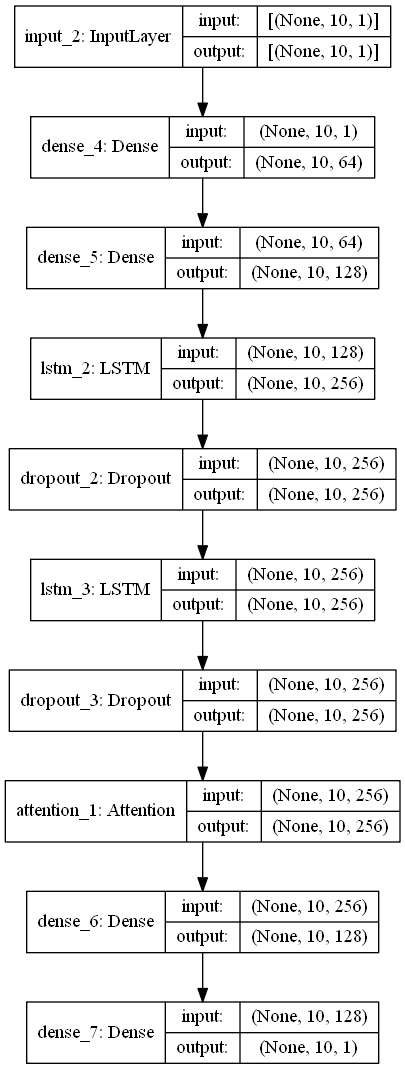

In [39]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True,)

In [40]:
#spliting it into the train and testing
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.30)

In [41]:
#A sample for predicting output while training each epoch
x = np.expand_dims(train_X[0], axis = 0)
x.shape

(1, 10)

In [42]:
x.shape

(1, 10)

# Defining A Call Function

In [43]:
class CallBacks(tf.keras.callbacks.Callback):
    
    def __init__(self,filepath):
        super(CallBacks,self).__init__()
        self.model_name = filepath
        
    def on_train_begin(self, logs = {}):
        self.losses = []
        self.acc = []
        self.logs = []
        keys = list(logs.keys())
        print("Starting epoch {} , got keys {}".format(len(self.losses)+1,keys))
    
    def on_epoch_end(self,epoch,logs = {}):
        current = logs.get('loss')
        # Appending logs, losses and accuracies to lists
        self.logs.append(logs)
        self.losses.append(logs.get("loss"))
        self.acc.append(logs.get("accuracy"))
        keys = list(logs.keys())
        print("End of epoch {} , got keys {} and accuracy is {}".format(len(self.losses), keys, logs['accuracy']))
        
        # Clear the previous plots
        N = np.arange(0,len(self.losses))
        print(N)
        # prediction over the sample x 
        prediction = self.model.predict(x)
        y_pred = np.array(prediction >= 0.5, dtype = np.int)
        print("Predicted : {}".format(y_pred[0][0][0]))
        print("Actual : {}".format(train_y[0]))
        
        # Plot the losses
        fig, axes = plt.subplots(1)
        plt.figure()
        
        axes.plot(N,self.losses, label = 'train_loss')
        axes.plot(N,self.acc, label = 'train_acc')
        fig.suptitle("Training Loss and Accuracy [Epoch {}]".format(epoch))
        axes.legend()
        plt.show()
plot_losses = CallBacks(filepath = '.')

In [44]:
x.reshape(-1,1).shape

(10, 1)

In [45]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)

early_stop = tf.keras.callbacks.EarlyStopping(
                            monitor = 'accuracy',
                            patience = 5,
                            restore_best_weights=True
                )

Starting epoch 1 , got keys []
Epoch 1/100
281/281 [==============================] - 40s 112ms/step - loss: 0.6904 - accuracy: 0.5304
End of epoch 1 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.5385971665382385
[0]
Predicted : 1
Actual : 1.0


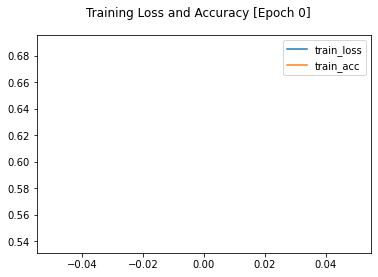

<Figure size 432x288 with 0 Axes>

Epoch 2/100
281/281 [==============================] - 30s 108ms/step - loss: 0.6853 - accuracy: 0.5445
End of epoch 2 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.5467492938041687
[0 1]
Predicted : 1
Actual : 1.0


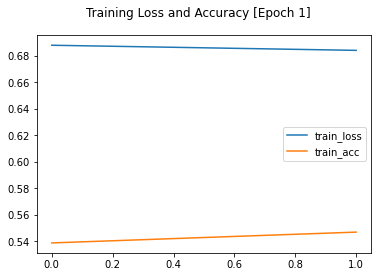

<Figure size 432x288 with 0 Axes>

Epoch 3/100
281/281 [==============================] - 29s 104ms/step - loss: 0.6789 - accuracy: 0.5599
End of epoch 3 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.5655291676521301
[0 1 2]
Predicted : 1
Actual : 1.0


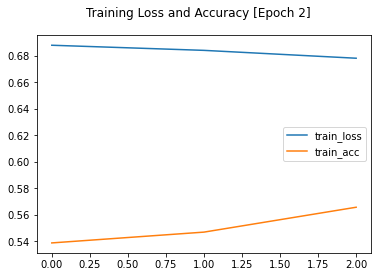

<Figure size 432x288 with 0 Axes>

Epoch 4/100
281/281 [==============================] - 36s 128ms/step - loss: 0.6746 - accuracy: 0.5825
End of epoch 4 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.5829149484634399
[0 1 2 3]
Predicted : 1
Actual : 1.0


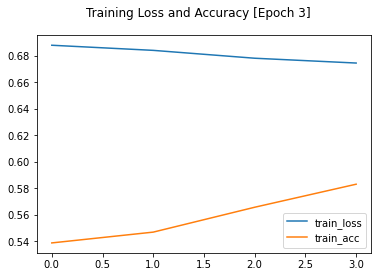

<Figure size 432x288 with 0 Axes>

Epoch 5/100
281/281 [==============================] - 33s 117ms/step - loss: 0.6719 - accuracy: 0.5877
End of epoch 5 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.5841532349586487
[0 1 2 3 4]
Predicted : 1
Actual : 1.0


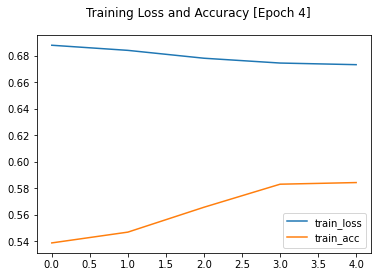

<Figure size 432x288 with 0 Axes>

Epoch 6/100
281/281 [==============================] - 29s 104ms/step - loss: 0.6636 - accuracy: 0.6039
End of epoch 6 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.5973456501960754
[0 1 2 3 4 5]
Predicted : 0
Actual : 1.0


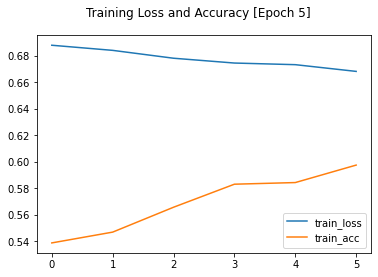

<Figure size 432x288 with 0 Axes>

Epoch 7/100
281/281 [==============================] - 29s 104ms/step - loss: 0.6701 - accuracy: 0.6017
End of epoch 7 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6020965576171875
[0 1 2 3 4 5 6]
Predicted : 1
Actual : 1.0


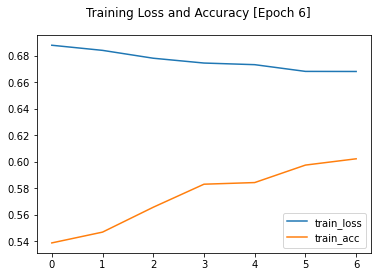

<Figure size 432x288 with 0 Axes>

Epoch 8/100
281/281 [==============================] - 32s 114ms/step - loss: 0.6684 - accuracy: 0.5985
End of epoch 8 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6013381481170654
[0 1 2 3 4 5 6 7]
Predicted : 1
Actual : 1.0


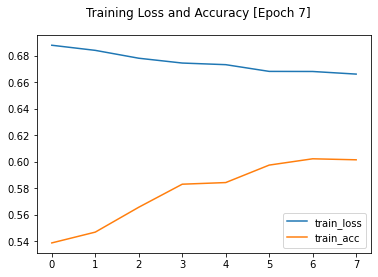

<Figure size 432x288 with 0 Axes>

Epoch 9/100
281/281 [==============================] - 30s 107ms/step - loss: 0.6675 - accuracy: 0.5984
End of epoch 9 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6072263717651367
[0 1 2 3 4 5 6 7 8]
Predicted : 1
Actual : 1.0


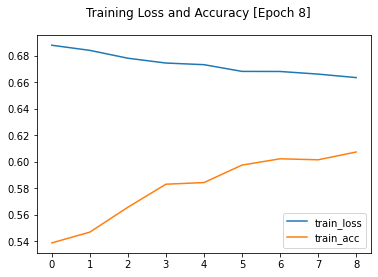

<Figure size 432x288 with 0 Axes>

Epoch 10/100
281/281 [==============================] - 33s 119ms/step - loss: 0.6589 - accuracy: 0.6179
End of epoch 10 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6126019358634949
[0 1 2 3 4 5 6 7 8 9]
Predicted : 1
Actual : 1.0


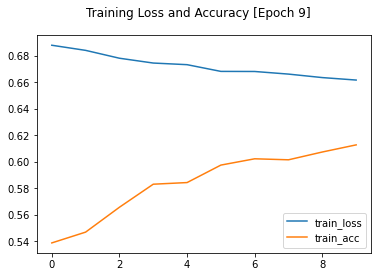

<Figure size 432x288 with 0 Axes>

Epoch 11/100
281/281 [==============================] - 33s 117ms/step - loss: 0.6637 - accuracy: 0.6045
End of epoch 11 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6053751707077026
[ 0  1  2  3  4  5  6  7  8  9 10]
Predicted : 1
Actual : 1.0


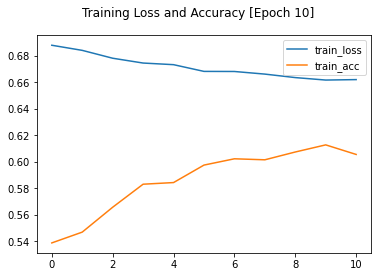

<Figure size 432x288 with 0 Axes>

Epoch 12/100
281/281 [==============================] - 29s 104ms/step - loss: 0.6612 - accuracy: 0.6006
End of epoch 12 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6081412434577942
[ 0  1  2  3  4  5  6  7  8  9 10 11]
Predicted : 1
Actual : 1.0


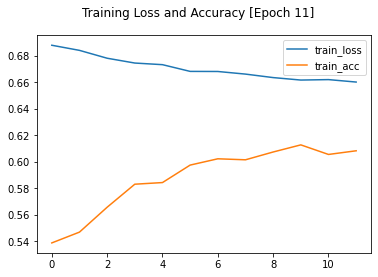

<Figure size 432x288 with 0 Axes>

Epoch 13/100
281/281 [==============================] - 30s 108ms/step - loss: 0.6582 - accuracy: 0.6135
End of epoch 13 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6109065413475037
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Predicted : 1
Actual : 1.0


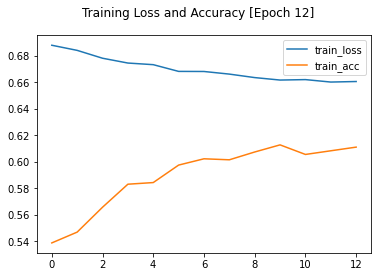

<Figure size 432x288 with 0 Axes>

Epoch 14/100
281/281 [==============================] - 32s 115ms/step - loss: 0.6547 - accuracy: 0.6180
End of epoch 14 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6110627055168152
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Predicted : 1
Actual : 1.0


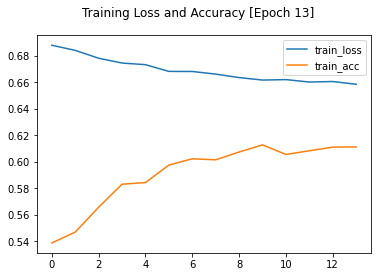

<Figure size 432x288 with 0 Axes>

Epoch 15/100
281/281 [==============================] - 32s 113ms/step - loss: 0.6580 - accuracy: 0.6124
End of epoch 15 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.616438090801239
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Predicted : 1
Actual : 1.0


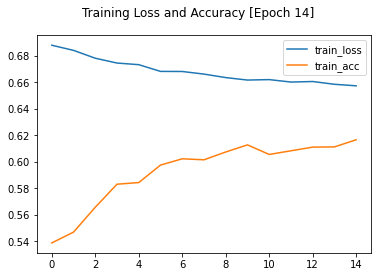

<Figure size 432x288 with 0 Axes>

Epoch 16/100
281/281 [==============================] - 32s 114ms/step - loss: 0.6534 - accuracy: 0.6208
End of epoch 16 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.61053866147995
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Predicted : 1
Actual : 1.0


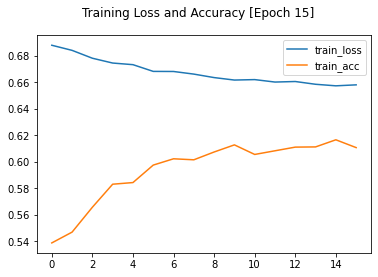

<Figure size 432x288 with 0 Axes>

Epoch 17/100
281/281 [==============================] - 32s 115ms/step - loss: 0.6583 - accuracy: 0.6118
End of epoch 17 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6175645589828491
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Predicted : 1
Actual : 1.0


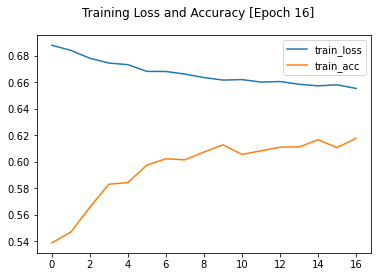

<Figure size 432x288 with 0 Axes>

Epoch 18/100
281/281 [==============================] - 29s 104ms/step - loss: 0.6536 - accuracy: 0.6140
End of epoch 18 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6168727874755859
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Predicted : 1
Actual : 1.0


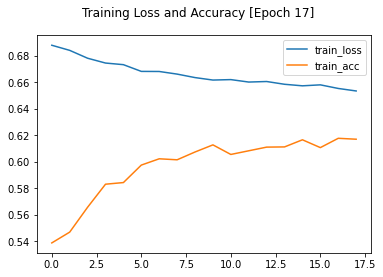

<Figure size 432x288 with 0 Axes>

Epoch 19/100
281/281 [==============================] - 29s 104ms/step - loss: 0.6526 - accuracy: 0.6165
End of epoch 19 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6184677481651306
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Predicted : 1
Actual : 1.0


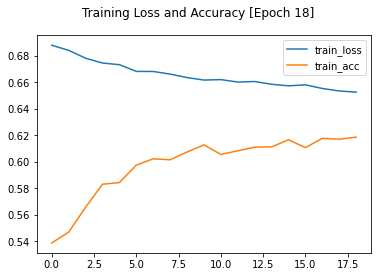

<Figure size 432x288 with 0 Axes>

Epoch 20/100
281/281 [==============================] - 29s 104ms/step - loss: 0.6495 - accuracy: 0.6240
End of epoch 20 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6194489002227783
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Predicted : 1
Actual : 1.0


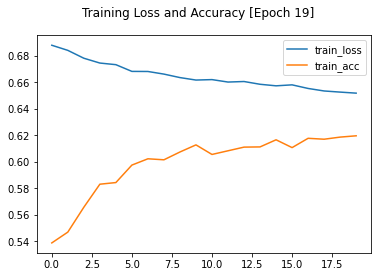

<Figure size 432x288 with 0 Axes>

Epoch 21/100
281/281 [==============================] - 29s 104ms/step - loss: 0.6470 - accuracy: 0.6219
End of epoch 21 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6217796802520752
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Predicted : 1
Actual : 1.0


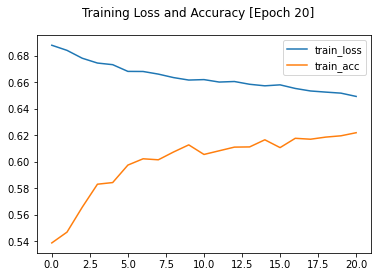

<Figure size 432x288 with 0 Axes>

Epoch 22/100
281/281 [==============================] - 30s 108ms/step - loss: 0.6513 - accuracy: 0.6196
End of epoch 22 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6218133568763733
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Predicted : 1
Actual : 1.0


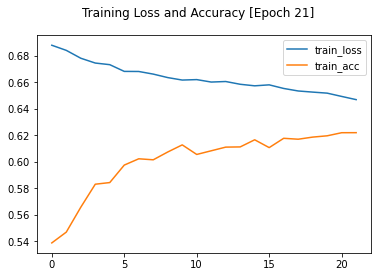

<Figure size 432x288 with 0 Axes>

Epoch 23/100
281/281 [==============================] - 29s 105ms/step - loss: 0.6474 - accuracy: 0.6137
End of epoch 23 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6169286370277405
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Predicted : 1
Actual : 1.0


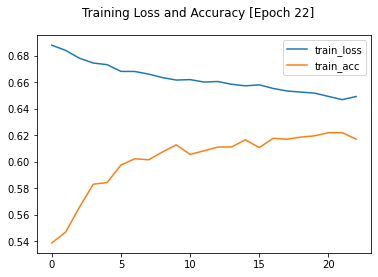

<Figure size 432x288 with 0 Axes>

Epoch 24/100
281/281 [==============================] - 29s 104ms/step - loss: 0.6458 - accuracy: 0.6221
End of epoch 24 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6229729652404785
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Predicted : 1
Actual : 1.0


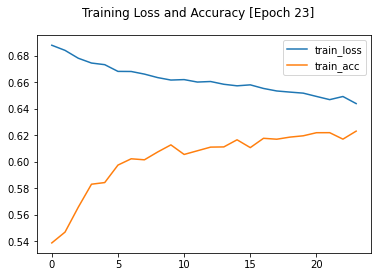

<Figure size 432x288 with 0 Axes>

Epoch 25/100
281/281 [==============================] - 29s 104ms/step - loss: 0.6468 - accuracy: 0.6157
End of epoch 25 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6253600120544434
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Predicted : 0
Actual : 1.0


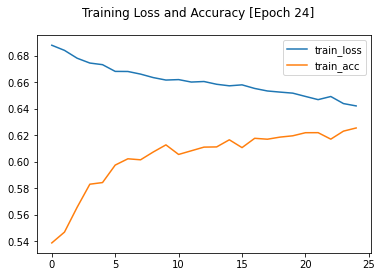

<Figure size 432x288 with 0 Axes>

Epoch 26/100
281/281 [==============================] - 31s 111ms/step - loss: 0.6457 - accuracy: 0.6213
End of epoch 26 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6279134154319763
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Predicted : 1
Actual : 1.0


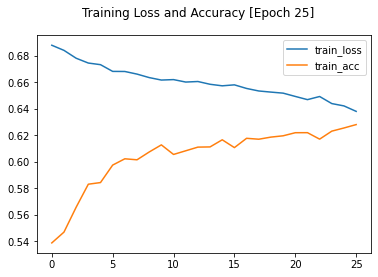

<Figure size 432x288 with 0 Axes>

Epoch 27/100
281/281 [==============================] - 34s 122ms/step - loss: 0.6312 - accuracy: 0.6334
End of epoch 27 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6284043788909912
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
Predicted : 1
Actual : 1.0


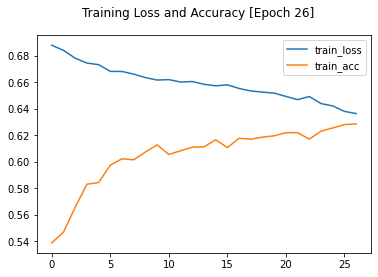

<Figure size 432x288 with 0 Axes>

Epoch 28/100
281/281 [==============================] - 37s 131ms/step - loss: 0.6302 - accuracy: 0.6329
End of epoch 28 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.631783127784729
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Predicted : 1
Actual : 1.0


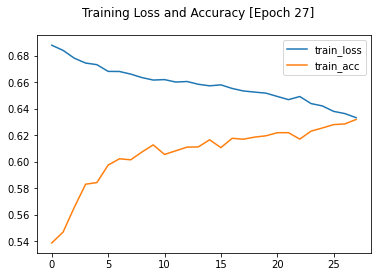

<Figure size 432x288 with 0 Axes>

Epoch 29/100
281/281 [==============================] - 35s 125ms/step - loss: 0.6205 - accuracy: 0.6392
End of epoch 29 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6346266865730286
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Predicted : 1
Actual : 1.0


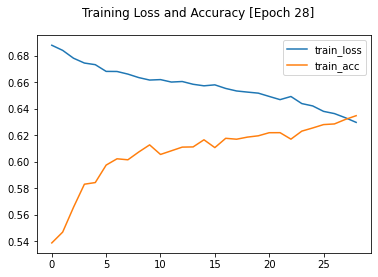

<Figure size 432x288 with 0 Axes>

Epoch 30/100
281/281 [==============================] - 33s 117ms/step - loss: 0.6242 - accuracy: 0.6413
End of epoch 30 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6401026248931885
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Predicted : 1
Actual : 1.0


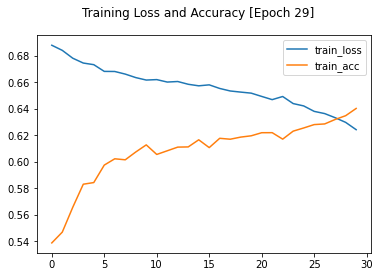

<Figure size 432x288 with 0 Axes>

Epoch 31/100
281/281 [==============================] - 35s 125ms/step - loss: 0.6253 - accuracy: 0.6389
End of epoch 31 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6409950852394104
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Predicted : 1
Actual : 1.0


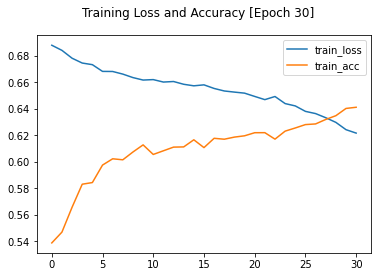

<Figure size 432x288 with 0 Axes>

Epoch 32/100
281/281 [==============================] - 33s 119ms/step - loss: 0.6123 - accuracy: 0.6513
End of epoch 32 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6468387246131897
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Predicted : 1
Actual : 1.0


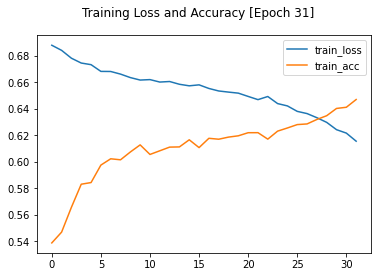

<Figure size 432x288 with 0 Axes>

Epoch 33/100
281/281 [==============================] - 32s 113ms/step - loss: 0.6067 - accuracy: 0.6596
End of epoch 33 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6545446515083313
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
Predicted : 1
Actual : 1.0


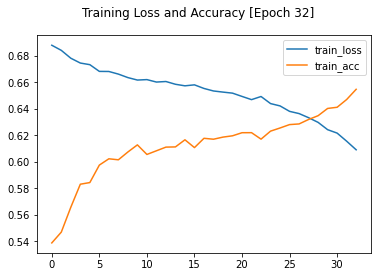

<Figure size 432x288 with 0 Axes>

Epoch 34/100
281/281 [==============================] - 34s 119ms/step - loss: 0.5974 - accuracy: 0.6638
End of epoch 34 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6577230095863342
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Predicted : 0
Actual : 1.0


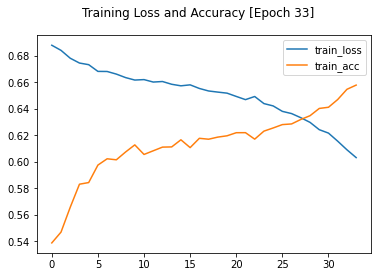

<Figure size 432x288 with 0 Axes>

Epoch 35/100
281/281 [==============================] - 41s 147ms/step - loss: 0.5924 - accuracy: 0.6643
End of epoch 35 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6629083156585693
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Predicted : 1
Actual : 1.0


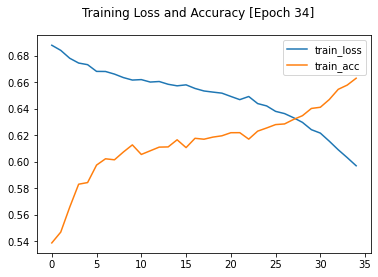

<Figure size 432x288 with 0 Axes>

Epoch 36/100
281/281 [==============================] - 38s 134ms/step - loss: 0.5824 - accuracy: 0.6714
End of epoch 36 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6624956727027893
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Predicted : 1
Actual : 1.0


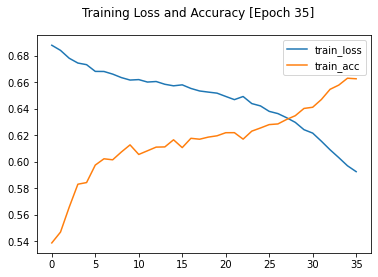

<Figure size 432x288 with 0 Axes>

Epoch 37/100
281/281 [==============================] - 34s 121ms/step - loss: 0.5838 - accuracy: 0.6745
End of epoch 37 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6711384057998657
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
Predicted : 1
Actual : 1.0


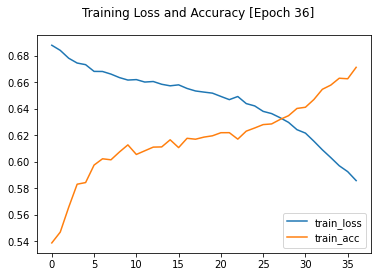

<Figure size 432x288 with 0 Axes>

Epoch 38/100
281/281 [==============================] - 36s 127ms/step - loss: 0.5708 - accuracy: 0.6831
End of epoch 38 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6827143430709839
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
Predicted : 1
Actual : 1.0


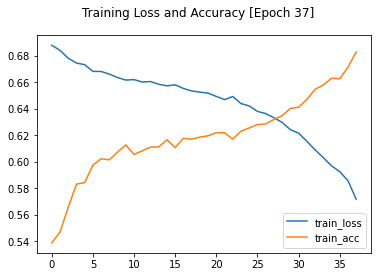

<Figure size 432x288 with 0 Axes>

Epoch 39/100
281/281 [==============================] - 30s 107ms/step - loss: 0.5642 - accuracy: 0.6899
End of epoch 39 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6884020566940308
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Predicted : 1
Actual : 1.0


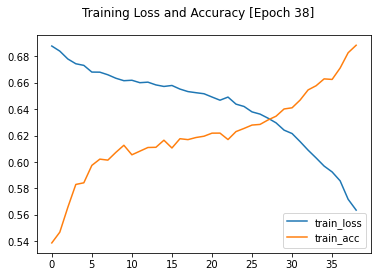

<Figure size 432x288 with 0 Axes>

Epoch 40/100
281/281 [==============================] - 34s 120ms/step - loss: 0.5565 - accuracy: 0.6955
End of epoch 40 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6915133595466614
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Predicted : 1
Actual : 1.0


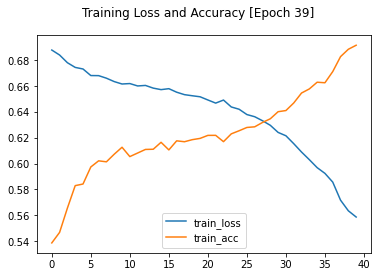

<Figure size 432x288 with 0 Axes>

Epoch 41/100
281/281 [==============================] - 29s 102ms/step - loss: 0.5465 - accuracy: 0.6953
End of epoch 41 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.6972674131393433
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Predicted : 1
Actual : 1.0


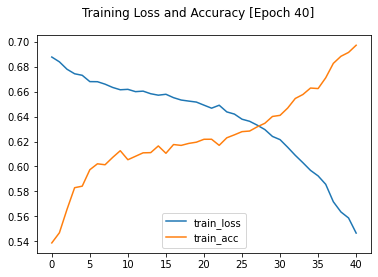

<Figure size 432x288 with 0 Axes>

Epoch 42/100
281/281 [==============================] - 25s 89ms/step - loss: 0.5293 - accuracy: 0.71530s - loss: 0.5
End of epoch 42 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.708441972732544
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Predicted : 1
Actual : 1.0


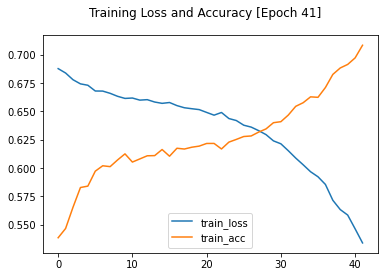

<Figure size 432x288 with 0 Axes>

Epoch 43/100
281/281 [==============================] - 24s 86ms/step - loss: 0.5168 - accuracy: 0.7180
End of epoch 43 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.7151554226875305
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Predicted : 1
Actual : 1.0


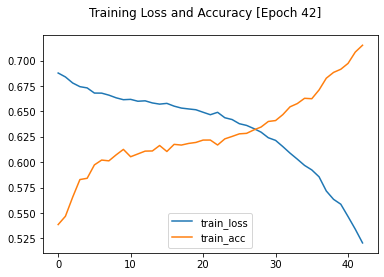

<Figure size 432x288 with 0 Axes>

Epoch 44/100
281/281 [==============================] - 24s 86ms/step - loss: 0.5168 - accuracy: 0.7209
End of epoch 44 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.7188131213188171
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Predicted : 1
Actual : 1.0


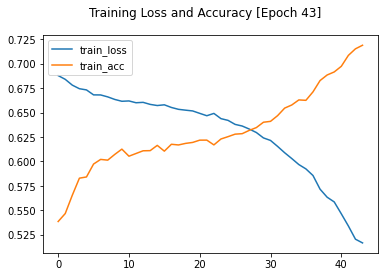

<Figure size 432x288 with 0 Axes>

Epoch 45/100
281/281 [==============================] - 24s 86ms/step - loss: 0.5019 - accuracy: 0.72640s - loss: 0.5018 - accuracy: 
End of epoch 45 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.724500834941864
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Predicted : 1
Actual : 1.0


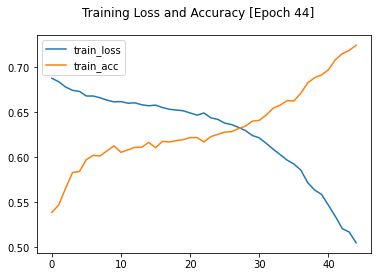

<Figure size 432x288 with 0 Axes>

Epoch 46/100
281/281 [==============================] - 24s 86ms/step - loss: 0.4928 - accuracy: 0.7366
End of epoch 46 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.7339131236076355
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
Predicted : 1
Actual : 1.0


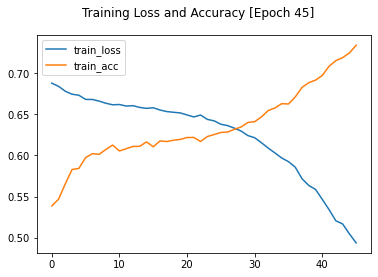

<Figure size 432x288 with 0 Axes>

Epoch 47/100
281/281 [==============================] - 24s 84ms/step - loss: 0.4717 - accuracy: 0.7476
End of epoch 47 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.7435817122459412
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Predicted : 1
Actual : 1.0


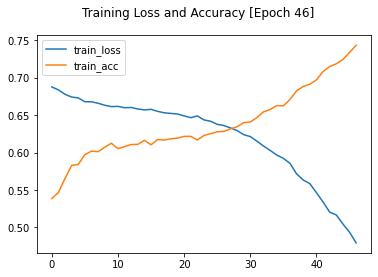

<Figure size 432x288 with 0 Axes>

Epoch 48/100
281/281 [==============================] - 24s 85ms/step - loss: 0.4605 - accuracy: 0.7592
End of epoch 48 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.7531167268753052
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Predicted : 1
Actual : 1.0


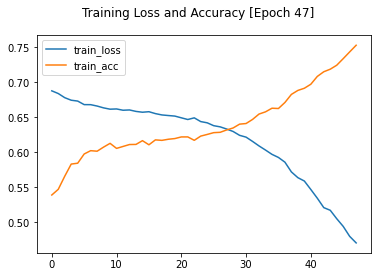

<Figure size 432x288 with 0 Axes>

Epoch 49/100
281/281 [==============================] - 24s 85ms/step - loss: 0.4539 - accuracy: 0.7609
End of epoch 49 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.762183427810669
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]
Predicted : 1
Actual : 1.0


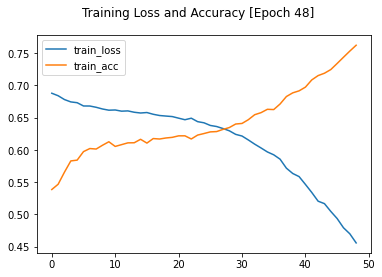

<Figure size 432x288 with 0 Axes>

Epoch 50/100
281/281 [==============================] - 23s 82ms/step - loss: 0.4437 - accuracy: 0.7702
End of epoch 50 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.7634546160697937
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Predicted : 1
Actual : 1.0


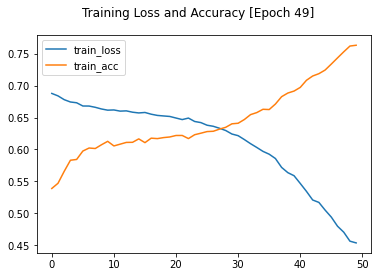

<Figure size 432x288 with 0 Axes>

Epoch 51/100
281/281 [==============================] - 24s 84ms/step - loss: 0.4362 - accuracy: 0.7758
End of epoch 51 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.7764137387275696
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
Predicted : 1
Actual : 1.0


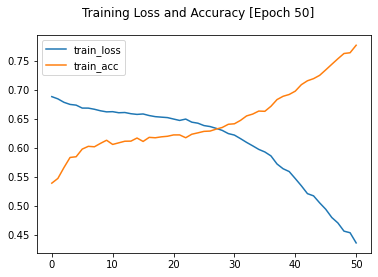

<Figure size 432x288 with 0 Axes>

Epoch 52/100
281/281 [==============================] - 24s 86ms/step - loss: 0.4159 - accuracy: 0.7910
End of epoch 52 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.7879782915115356
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]
Predicted : 1
Actual : 1.0


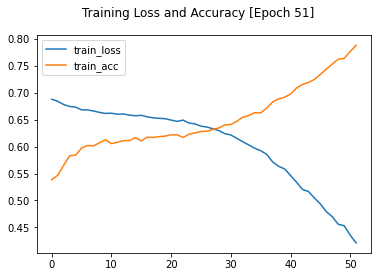

<Figure size 432x288 with 0 Axes>

Epoch 53/100
281/281 [==============================] - 25s 87ms/step - loss: 0.4143 - accuracy: 0.7877
End of epoch 53 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.7849336266517639
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
Predicted : 1
Actual : 1.0


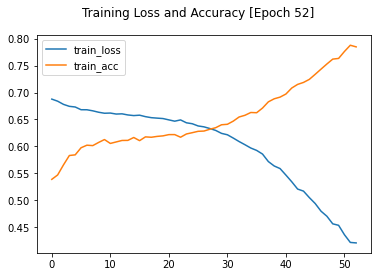

<Figure size 432x288 with 0 Axes>

Epoch 54/100
281/281 [==============================] - 26s 91ms/step - loss: 0.4040 - accuracy: 0.7981
End of epoch 54 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.7907771468162537
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53]
Predicted : 1
Actual : 1.0


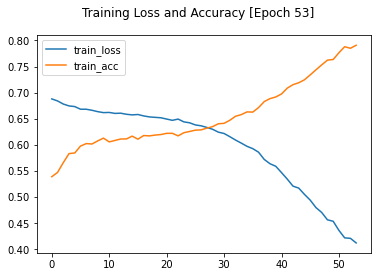

<Figure size 432x288 with 0 Axes>

Epoch 55/100
281/281 [==============================] - 36s 129ms/step - loss: 0.3859 - accuracy: 0.8058
End of epoch 55 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.799821674823761
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54]
Predicted : 1
Actual : 1.0


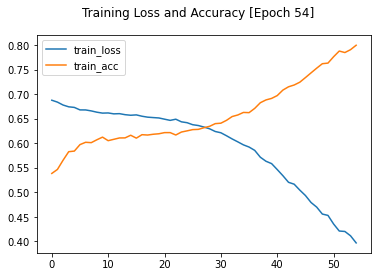

<Figure size 432x288 with 0 Axes>

Epoch 56/100
281/281 [==============================] - 42s 148ms/step - loss: 0.3717 - accuracy: 0.8180
End of epoch 56 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8059329390525818
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
Predicted : 1
Actual : 1.0


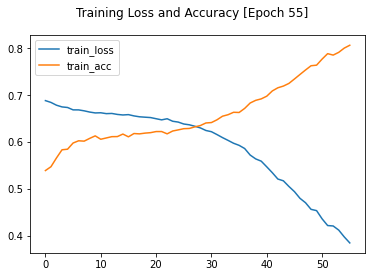

<Figure size 432x288 with 0 Axes>

Epoch 57/100
281/281 [==============================] - 37s 131ms/step - loss: 0.3815 - accuracy: 0.8063
End of epoch 57 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8058326840400696
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56]
Predicted : 1
Actual : 1.0


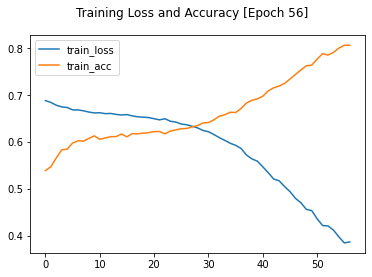

<Figure size 432x288 with 0 Axes>

Epoch 58/100
281/281 [==============================] - 33s 118ms/step - loss: 0.3738 - accuracy: 0.8100
End of epoch 58 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8115532994270325
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]
Predicted : 1
Actual : 1.0


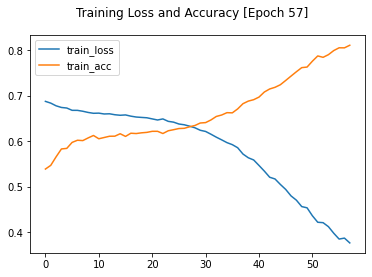

<Figure size 432x288 with 0 Axes>

Epoch 59/100
281/281 [==============================] - 31s 111ms/step - loss: 0.3700 - accuracy: 0.8149
End of epoch 59 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8124234676361084
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]
Predicted : 1
Actual : 1.0


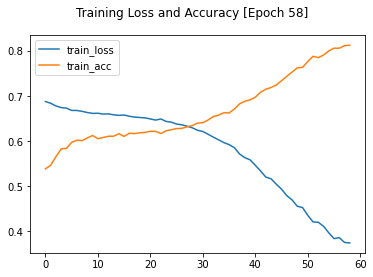

<Figure size 432x288 with 0 Axes>

Epoch 60/100
281/281 [==============================] - 32s 112ms/step - loss: 0.3628 - accuracy: 0.8210
End of epoch 60 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8176652193069458
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Predicted : 1
Actual : 1.0


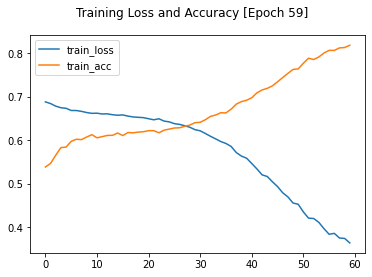

<Figure size 432x288 with 0 Axes>

Epoch 61/100
281/281 [==============================] - 32s 114ms/step - loss: 0.3363 - accuracy: 0.8292
End of epoch 61 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8308799266815186
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60]
Predicted : 1
Actual : 1.0


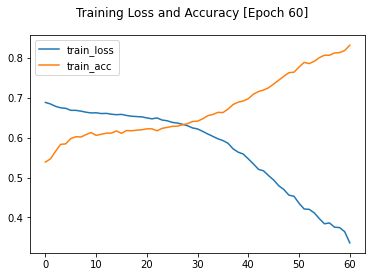

<Figure size 432x288 with 0 Axes>

Epoch 62/100
281/281 [==============================] - 32s 113ms/step - loss: 0.3348 - accuracy: 0.8353
End of epoch 62 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.829530656337738
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
Predicted : 1
Actual : 1.0


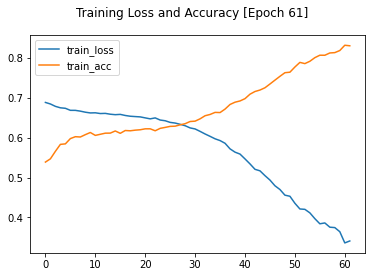

<Figure size 432x288 with 0 Axes>

Epoch 63/100
281/281 [==============================] - 32s 114ms/step - loss: 0.3204 - accuracy: 0.8399
End of epoch 63 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8339244723320007
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
Predicted : 1
Actual : 1.0


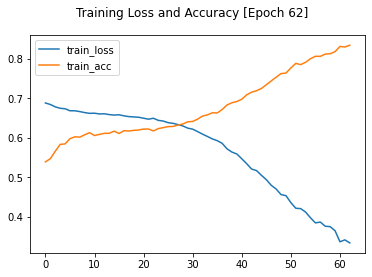

<Figure size 432x288 with 0 Axes>

Epoch 64/100
281/281 [==============================] - 33s 117ms/step - loss: 0.3209 - accuracy: 0.8471
End of epoch 64 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8384965658187866
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Predicted : 1
Actual : 1.0


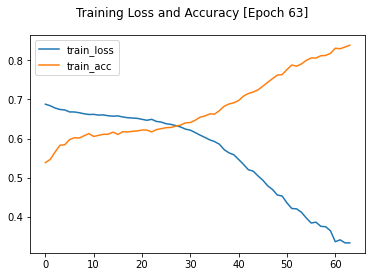

<Figure size 432x288 with 0 Axes>

Epoch 65/100
281/281 [==============================] - 33s 116ms/step - loss: 0.3167 - accuracy: 0.8508
End of epoch 65 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8389874696731567
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]
Predicted : 1
Actual : 1.0


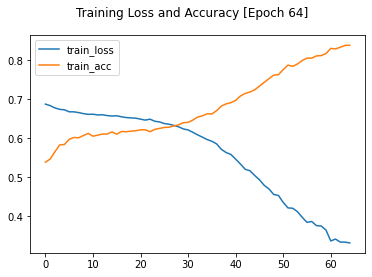

<Figure size 432x288 with 0 Axes>

Epoch 66/100
281/281 [==============================] - 32s 114ms/step - loss: 0.3053 - accuracy: 0.8526
End of epoch 66 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8451319336891174
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
Predicted : 1
Actual : 1.0


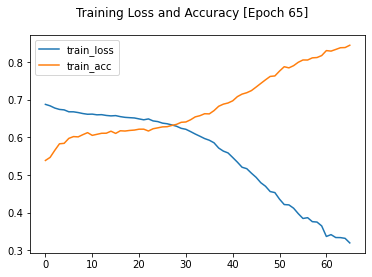

<Figure size 432x288 with 0 Axes>

Epoch 67/100
281/281 [==============================] - 34s 121ms/step - loss: 0.3081 - accuracy: 0.8519
End of epoch 67 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8469945192337036
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]
Predicted : 1
Actual : 1.0


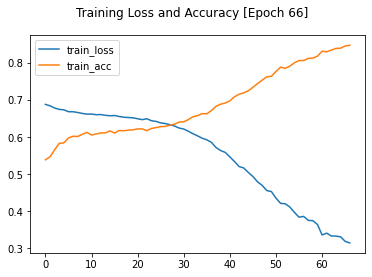

<Figure size 432x288 with 0 Axes>

Epoch 68/100
281/281 [==============================] - 34s 121ms/step - loss: 0.3053 - accuracy: 0.8514
End of epoch 68 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8479423522949219
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
Predicted : 1
Actual : 1.0


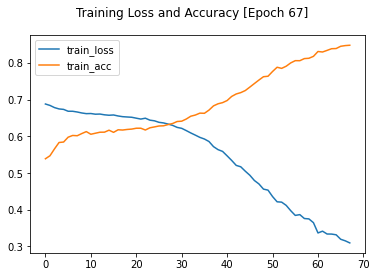

<Figure size 432x288 with 0 Axes>

Epoch 69/100
281/281 [==============================] - 31s 111ms/step - loss: 0.2971 - accuracy: 0.8544
End of epoch 69 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8497716188430786
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]
Predicted : 1
Actual : 1.0


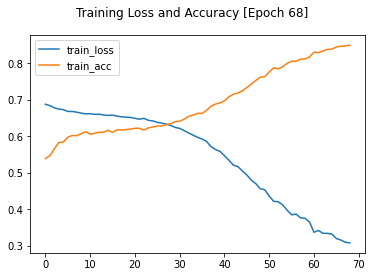

<Figure size 432x288 with 0 Axes>

Epoch 70/100
281/281 [==============================] - 31s 112ms/step - loss: 0.3144 - accuracy: 0.8449
End of epoch 70 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8480761647224426
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Predicted : 1
Actual : 1.0


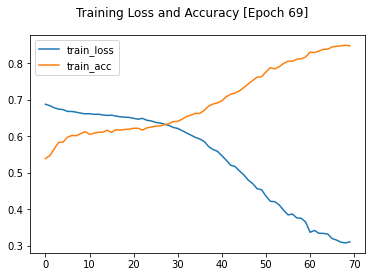

<Figure size 432x288 with 0 Axes>

Epoch 71/100
281/281 [==============================] - 31s 110ms/step - loss: 0.2971 - accuracy: 0.8569
End of epoch 71 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.857098400592804
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]
Predicted : 1
Actual : 1.0


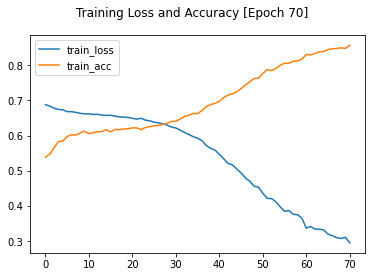

<Figure size 432x288 with 0 Axes>

Epoch 72/100
281/281 [==============================] - 32s 114ms/step - loss: 0.2732 - accuracy: 0.8715
End of epoch 72 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8621274828910828
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Predicted : 1
Actual : 1.0


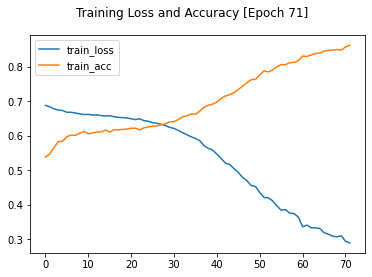

<Figure size 432x288 with 0 Axes>

Epoch 73/100
281/281 [==============================] - 31s 110ms/step - loss: 0.2885 - accuracy: 0.8600
End of epoch 73 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8554922342300415
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]
Predicted : 1
Actual : 1.0


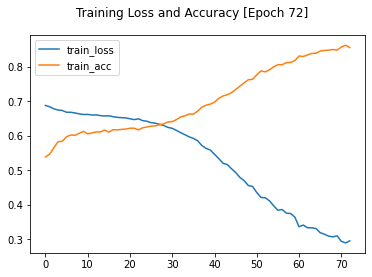

<Figure size 432x288 with 0 Axes>

Epoch 74/100
281/281 [==============================] - 31s 110ms/step - loss: 0.2860 - accuracy: 0.8604
End of epoch 74 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8643026351928711
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73]
Predicted : 1
Actual : 1.0


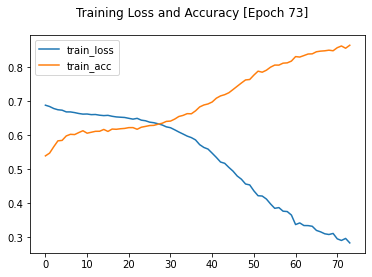

<Figure size 432x288 with 0 Axes>

Epoch 75/100
281/281 [==============================] - 31s 109ms/step - loss: 0.2734 - accuracy: 0.8688
End of epoch 75 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8683729767799377
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74]
Predicted : 1
Actual : 1.0


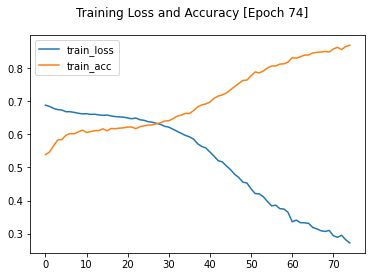

<Figure size 432x288 with 0 Axes>

Epoch 76/100
281/281 [==============================] - 32s 113ms/step - loss: 0.2631 - accuracy: 0.8756
End of epoch 76 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8676033616065979
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75]
Predicted : 1
Actual : 1.0


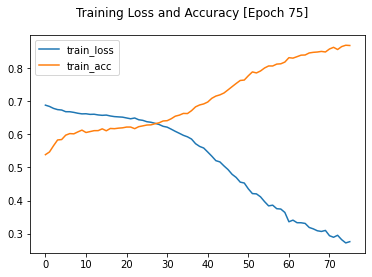

<Figure size 432x288 with 0 Axes>

Epoch 77/100
281/281 [==============================] - 32s 115ms/step - loss: 0.2823 - accuracy: 0.8675
End of epoch 77 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8631983995437622
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76]
Predicted : 1
Actual : 1.0


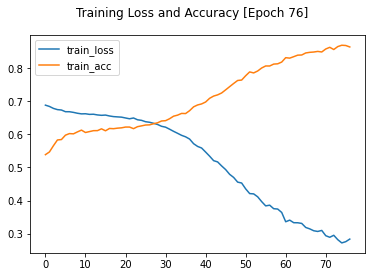

<Figure size 432x288 with 0 Axes>

Epoch 78/100
281/281 [==============================] - 34s 121ms/step - loss: 0.2615 - accuracy: 0.8772
End of epoch 78 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8681164979934692
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
Predicted : 1
Actual : 1.0


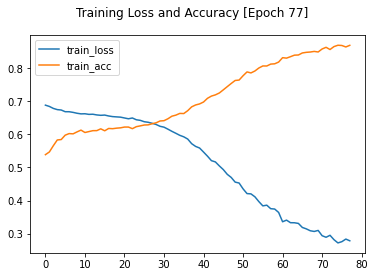

<Figure size 432x288 with 0 Axes>

Epoch 79/100
281/281 [==============================] - 33s 117ms/step - loss: 0.2740 - accuracy: 0.8751
End of epoch 79 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.873012125492096
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78]
Predicted : 1
Actual : 1.0


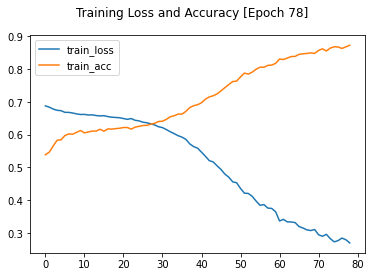

<Figure size 432x288 with 0 Axes>

Epoch 80/100
281/281 [==============================] - 39s 138ms/step - loss: 0.2410 - accuracy: 0.8870
End of epoch 80 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8768149614334106
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]
Predicted : 1
Actual : 1.0


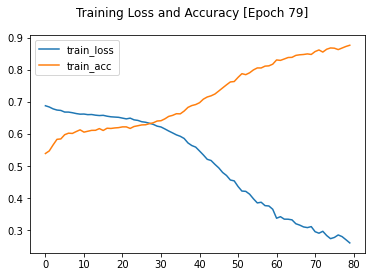

<Figure size 432x288 with 0 Axes>

Epoch 81/100
281/281 [==============================] - 37s 130ms/step - loss: 0.2624 - accuracy: 0.8787
End of epoch 81 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.882168173789978
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]
Predicted : 1
Actual : 1.0


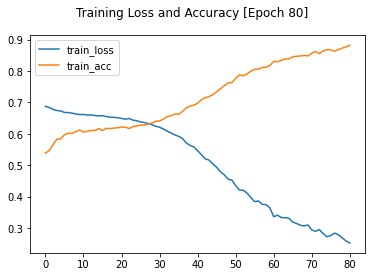

<Figure size 432x288 with 0 Axes>

Epoch 82/100
281/281 [==============================] - 35s 123ms/step - loss: 0.2350 - accuracy: 0.8913
End of epoch 82 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8812755346298218
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81]
Predicted : 1
Actual : 1.0


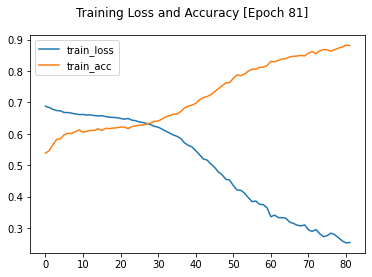

<Figure size 432x288 with 0 Axes>

Epoch 83/100
281/281 [==============================] - 32s 115ms/step - loss: 0.2401 - accuracy: 0.8818
End of epoch 83 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.885959267616272
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
Predicted : 1
Actual : 1.0


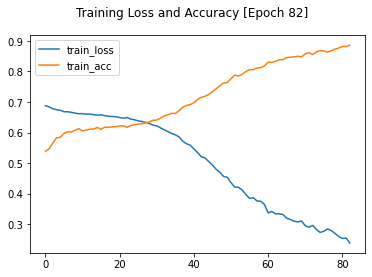

<Figure size 432x288 with 0 Axes>

Epoch 84/100
281/281 [==============================] - 31s 111ms/step - loss: 0.2618 - accuracy: 0.8779
End of epoch 84 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8793686032295227
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
Predicted : 1
Actual : 1.0


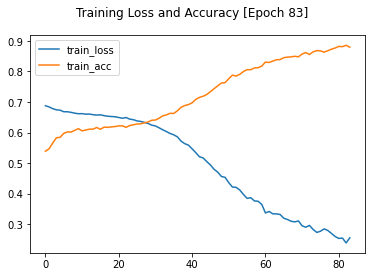

<Figure size 432x288 with 0 Axes>

Epoch 85/100
281/281 [==============================] - 31s 109ms/step - loss: 0.2240 - accuracy: 0.8937
End of epoch 85 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8877214789390564
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84]
Predicted : 1
Actual : 1.0


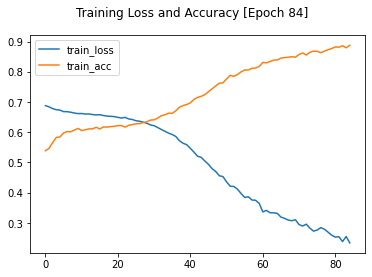

<Figure size 432x288 with 0 Axes>

Epoch 86/100
281/281 [==============================] - 31s 109ms/step - loss: 0.2366 - accuracy: 0.8892
End of epoch 86 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8830710649490356
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85]
Predicted : 1
Actual : 1.0


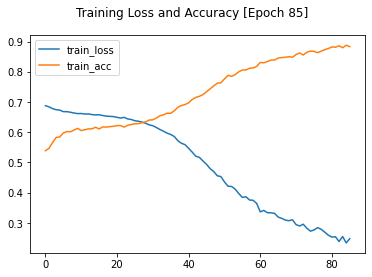

<Figure size 432x288 with 0 Axes>

Epoch 87/100
281/281 [==============================] - 32s 113ms/step - loss: 0.2530 - accuracy: 0.8796
End of epoch 87 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8816548585891724
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86]
Predicted : 1
Actual : 1.0


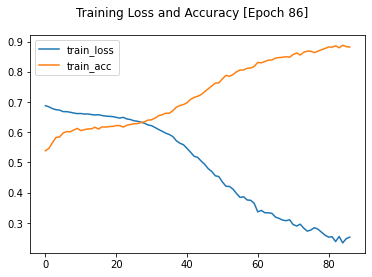

<Figure size 432x288 with 0 Axes>

Epoch 88/100
281/281 [==============================] - 34s 119ms/step - loss: 0.2417 - accuracy: 0.8885
End of epoch 88 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8909891247749329
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]
Predicted : 1
Actual : 1.0


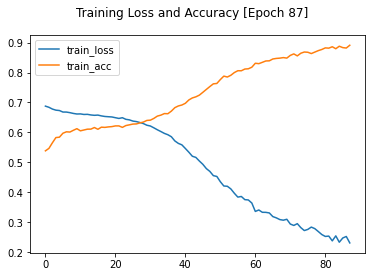

<Figure size 432x288 with 0 Axes>

Epoch 89/100
281/281 [==============================] - 30s 107ms/step - loss: 0.2210 - accuracy: 0.8965
End of epoch 89 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.889918327331543
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]
Predicted : 1
Actual : 1.0


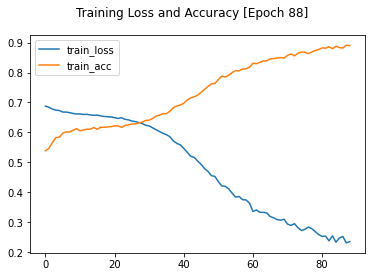

<Figure size 432x288 with 0 Axes>

Epoch 90/100
281/281 [==============================] - 23s 83ms/step - loss: 0.2161 - accuracy: 0.8974
End of epoch 90 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8956283330917358
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Predicted : 1
Actual : 1.0


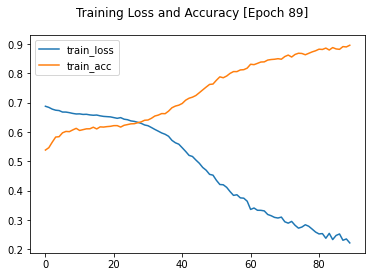

<Figure size 432x288 with 0 Axes>

Epoch 91/100
281/281 [==============================] - 24s 84ms/step - loss: 0.2154 - accuracy: 0.8971
End of epoch 91 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8900521993637085
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
Predicted : 1
Actual : 1.0


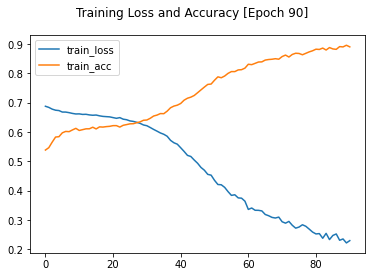

<Figure size 432x288 with 0 Axes>

Epoch 92/100
281/281 [==============================] - 23s 82ms/step - loss: 0.2150 - accuracy: 0.8984
End of epoch 92 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.8979255557060242
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
Predicted : 1
Actual : 1.0


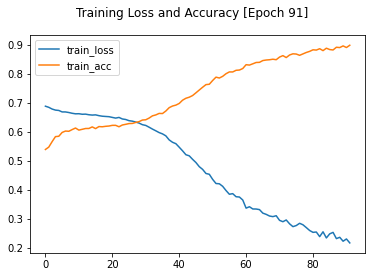

<Figure size 432x288 with 0 Axes>

Epoch 93/100
281/281 [==============================] - 23s 83ms/step - loss: 0.2094 - accuracy: 0.9036
End of epoch 93 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.9009034037590027
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]
Predicted : 1
Actual : 1.0


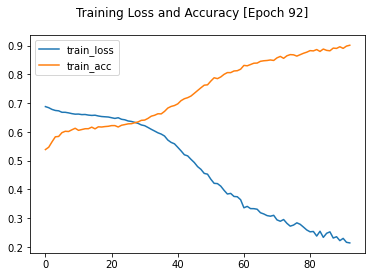

<Figure size 432x288 with 0 Axes>

Epoch 94/100
281/281 [==============================] - 24s 85ms/step - loss: 0.2049 - accuracy: 0.9049
End of epoch 94 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.898617148399353
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93]
Predicted : 1
Actual : 1.0


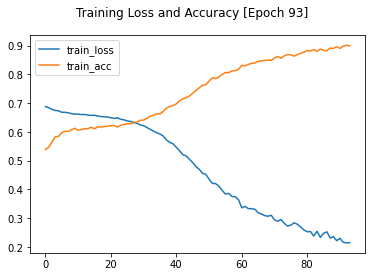

<Figure size 432x288 with 0 Axes>

Epoch 95/100
281/281 [==============================] - 24s 85ms/step - loss: 0.2124 - accuracy: 0.9005
End of epoch 95 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.9027989506721497
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
Predicted : 1
Actual : 1.0


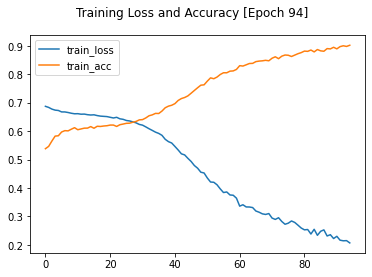

<Figure size 432x288 with 0 Axes>

Epoch 96/100
281/281 [==============================] - 23s 83ms/step - loss: 0.2038 - accuracy: 0.9083
End of epoch 96 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.9005463719367981
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Predicted : 1
Actual : 1.0


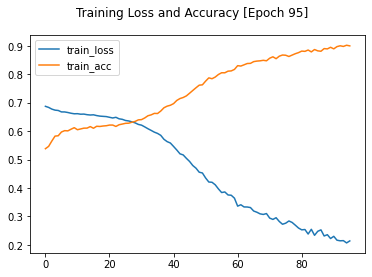

<Figure size 432x288 with 0 Axes>

Epoch 97/100
281/281 [==============================] - 23s 83ms/step - loss: 0.2100 - accuracy: 0.9065
End of epoch 97 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.9056429862976074
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96]
Predicted : 1
Actual : 1.0


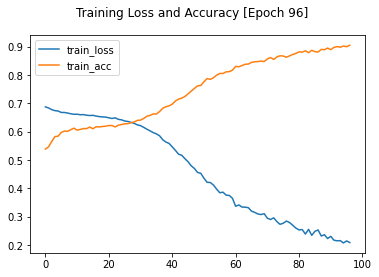

<Figure size 432x288 with 0 Axes>

Epoch 98/100
281/281 [==============================] - 24s 85ms/step - loss: 0.1845 - accuracy: 0.9188
End of epoch 98 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.9125235080718994
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97]
Predicted : 1
Actual : 1.0


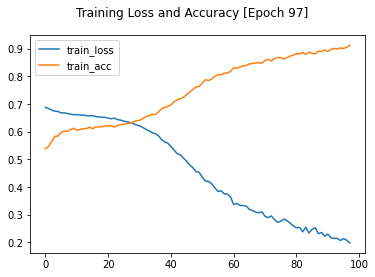

<Figure size 432x288 with 0 Axes>

Epoch 99/100
281/281 [==============================] - 24s 86ms/step - loss: 0.1908 - accuracy: 0.9132
End of epoch 99 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.9109959602355957
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98]
Predicted : 1
Actual : 1.0


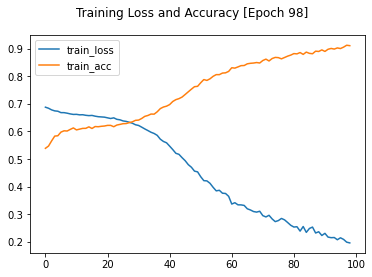

<Figure size 432x288 with 0 Axes>

Epoch 100/100
281/281 [==============================] - 26s 91ms/step - loss: 0.1734 - accuracy: 0.9239
End of epoch 100 , got keys ['loss', 'accuracy', 'lr'] and accuracy is 0.9128137826919556
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Predicted : 1
Actual : 1.0


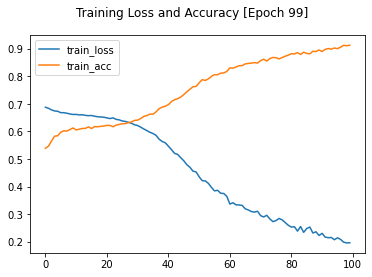

<Figure size 432x288 with 0 Axes>

In [46]:
# No callbacks
history = history1 = model.fit(X_train,batch_size=bs,
                   epochs = epochs,
                callbacks = [reduce_lr,plot_losses,early_stop])

In [47]:
!mkdir 'weights'

In [48]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


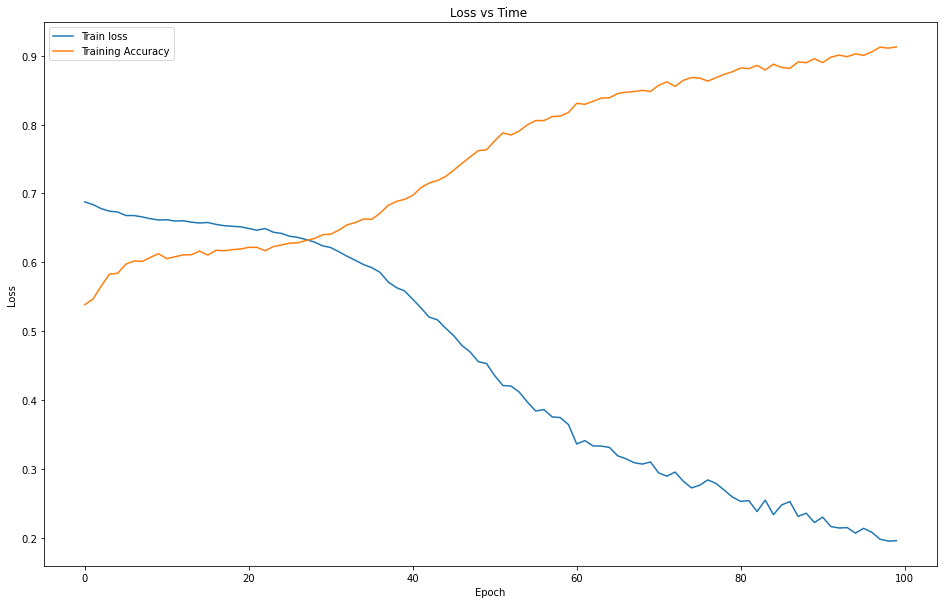

In [50]:
plt.figure(figsize = (16,10))
plt.plot(range(len(history1.history['loss'])),history1.history['loss'],label = 'Train loss')
plt.plot(range(len(history1.history['accuracy'])),history1.history['accuracy'],label = 'Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss vs Time ")
plt.legend()
plt.show()

In [51]:
train_X= np.reshape(train_X,(train_X.shape[0], train_X.shape[1],1))

print(train_X.shape)

test_X= np.reshape(test_X,(test_X.shape[0], test_X.shape[1],1))

print(test_X.shape)
print(test_y.shape)

(8967, 10, 1)
(3844, 10, 1)
(3844,)


In [52]:
best_acc,epoch_at = max(history1.history['accuracy']),history1.history['accuracy'].index(max(history1.history['accuracy']))
best_acc *= 100
print("Best Accuracy : {:.2f} % at epoch : {}".format(best_acc,epoch_at))

Best Accuracy : 91.28 % at epoch : 99


In [53]:
model.evaluate(test_X,test_y)

121/121 [==============================] - 6s 39ms/step - loss: 0.8074 - accuracy: 0.8034


[0.8073936104774475, 0.8033559918403625]

In [54]:
y_true = np.array(test_y)
y_pred = np.squeeze(model.predict(test_X))
y_pred

array([[9.9367541e-01, 9.9345028e-01, 9.9519134e-01, ..., 9.9477041e-01,
        9.9621093e-01, 9.9694359e-01],
       [1.2817740e-02, 1.3712764e-02, 1.1735737e-02, ..., 1.2418568e-02,
        9.9677742e-03, 9.6082091e-03],
       [3.8609803e-03, 3.8118064e-03, 3.9662123e-03, ..., 9.3271434e-03,
        5.2326918e-04, 5.9056282e-04],
       ...,
       [3.5647222e-01, 3.6933160e-01, 4.1396976e-01, ..., 3.7597564e-01,
        3.2023242e-01, 3.7177134e-01],
       [1.8010971e-01, 1.9901434e-01, 1.5295485e-01, ..., 1.9530123e-01,
        2.0613882e-01, 2.2647318e-01],
       [3.3824661e-01, 3.3971289e-01, 3.2131881e-01, ..., 3.4014362e-01,
        3.5070097e-01, 3.8097885e-01]], dtype=float32)

In [55]:
y_pred = np.array(y_pred >= 0.5, dtype = np.int)

In [56]:
np.expand_dims(test_X[0],axis = 0)
model.predict(np.expand_dims(test_X[0],axis = 0))

array([[[0.9936754 ],
        [0.9934503 ],
        [0.9951914 ],
        [0.9956988 ],
        [0.9933895 ],
        [0.9960016 ],
        [0.99391246],
        [0.9947704 ],
        [0.9962109 ],
        [0.9969436 ]]], dtype=float32)